In [6]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
from sklearn.decomposition import NMF
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [7]:
##########################
#SET DE FUNCIONES COMUNES#
##########################

import os
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spellchecker import SpellChecker
import pandas as pd

def interpret_topics(n_componentes,algoritmo,vectorial_object):
    #Interpretacion de los tópicos
    diccionario_topics = {}
    vocabulary = {item:key for key,item in  vectorial_object.vocabulary_.items()}
    
    for componente in range(n_componentes):
      lista_ordenada = sorted(range(algoritmo.components_.shape[1]),reverse = True,key = lambda x: algoritmo.components_[componente][x])[:10]
      print(f'Topic {componente +1 }: \n')
      print(lista_ordenada)
      temas_topic = ', '.join(vocabulary[i] for i in lista_ordenada)
      print(temas_topic)
      diccionario_topics.update({componente:temas_topic})
      print('\n')
      
      
    return diccionario_topics,vocabulary

def export_json_topics(algoritmo,diccionario_topics):

    directorio_destino_topics = 'topics/'
    with open(os.path.join(directorio_destino_topics,f'topics_{algoritmo}.json'),'w',encoding='utf8') as f:
        json.dump(diccionario_topics, f, indent= 2,ensure_ascii=False)

    f.close()


    
def sentence_corrector(diccionario, language):
    diccionario_corregido = {}
    for key in range(len(diccionario.keys())):
        print(key)
        print(diccionario[key])
        speller = SpellChecker(language=language)
        
        values = diccionario[key]
        values = [i.strip() for i in values ]
        print(values)
        
        list_correct_words = [speller.correction(word) if speller.correction(word) is not None else word for word in values ]
        diccionario_corregido[key]= list_correct_words
    return diccionario_corregido


def worcloud_topics(n_componentes,algoritmo,vocabulary,file_name):
    #Wordclouds
    
    wc_atributos = {
        'height':800,
        'width':1200,
        'background_color':'white',
        'max_words' : 20
        }
    
    fig,axs = plt.subplots(n_componentes,figsize = (6,20))
    
    
    for n in range(n_componentes):
        lista_ordenada = sorted(range(algoritmo.components_.shape[1]),reverse = True,key = lambda x: algoritmo.components_[n][x])[:10]
        print(lista_ordenada)
        compt_dict = {vocabulary[i]: algoritmo.components_[n][i] for i in lista_ordenada}
        wc = WordCloud(**wc_atributos).generate_from_frequencies(compt_dict)
        
        axs[n].set_title(f'Tópico {n+1}')
        axs[n].imshow(wc)
        axs[n].axis('off')
        
    plt.savefig('image_topics/wc_topics_'+file_name+'.png')
    plt.show()


def distribution_topics(bow,predominant_topics,algorithm):
    # Crear un DataFrame para mostrar los resultados
    df_results = pd.DataFrame({
        'Documento': range(bow.shape[0]),
        'Tema Dominante': predominant_topics
    })
    
  
    df_results['Tema Dominante'] = df_results['Tema Dominante'].apply(lambda x: x+1)

    topic_counts = df_results['Tema Dominante'].value_counts()
     
    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    topic_counts.plot(kind='bar')
    plt.xlabel('Tema')
    plt.ylabel('Frecuencia')
    plt.title('Frecuencia de aparición de cada tema')
    plt.xticks(rotation=0)  # Rotar etiquetas del eje x si es necesario
    plt.savefig('image_topics/'+algorithm+'_distribution_topics.png')
    plt.show()
    
def serializar_lista(lista,name):
    try:
        lista_to_serie = pd.Series(lista)
        lista_to_serie.to_pickle(name+'.pkl')
        print('Los tópicos se han asignado correctamente')
    except:
        print('NO se ha posido serializar la lista de asignación correctamente')

In [8]:
stopwords = nltk.corpus.stopwords.words('english')

data = pd.read_csv('data/data_sentiment_analisis.csv',index_col = None)

In [9]:
#En este aso se construye la matriz con el modelo vectorial Tf-idf, es decir, ponderando la ferecuencia del término por la especificidad.

#Se procederá en dos pasos:
#    1 .Modelo Bag of Words (BOW)
#    2. Aplicar suavizado con la especificidad idf


bow_object = CountVectorizer(
    max_df = 0.7, #Eliminar términos que aparezcan con una frecuencia superior a f (en este caso 70%)
    stop_words = stopwords
)

bow = bow_object.fit_transform(data['review_preprocesada'])

#Construcción del tf-idf
print(f'Las dimensiones de la matriz de representación vectorial es {bow.shape}')

tfidf_object = TfidfTransformer(norm = 'l2')
tfidf = tfidf_object.fit_transform(bow)

#Ajustamos y entrenamos el modelo de detección de tópicos NMF
components = 10
nmf_object = NMF(n_components=components,
                 random_state=123,
                 init= 'nndsvda'
)
nmf = nmf_object.fit_transform(tfidf)


# Identificar el tópico predominante para cada documento
predominant_topics = np.argmax(nmf, axis=1)
serializar_lista(lista=predominant_topics,name='asig_topics/topics_asig_nmf')


Las dimensiones de la matriz de representación vectorial es (79045, 29651)
Los tópicos se han asignado correctamente


Topic 1: 

[10951, 20861, 1765, 4268, 9867, 2663, 17269, 12458, 15025, 27553]
game, recommend, amazing, buy, favorite, awesome, nice, highly, like, update


Topic 2: 

[11439, 9301, 19826, 24585, 11589, 24506, 10968, 19846, 10951, 12077]
good, ever, pretty, story, graphic, still, gamelan, price, game, hard


Topic 3: 

[10822, 10702, 15314, 24980, 19826, 16842, 15129, 6740, 23212, 8595]
fun, friend, lot, super, pretty, much, little, cute, simple, easy


Topic 4: 

[11637, 24585, 11589, 20306, 26001, 10968, 16935, 5194, 23882, 2263]
great, story, graphic, puzzle, time, gamelan, music, classic, soundtrack, art


Topic 5: 

[19234, 10702, 9301, 12750, 26001, 28951, 28190, 24564, 10139, 17233]
play, friend, ever, hour, time, year, want, stop, first, never


Topic 6: 

[15332, 16842, 1150, 1765, 6740, 3074, 4619, 22601, 2263, 24761]
love, much, absolutely, amazing, cute, beautiful, cat, see, art, style


Topic 7: 

[26001, 15564, 9910, 24585, 11380, 4847, 9291, 1727, 25832, 15314]
time, mak

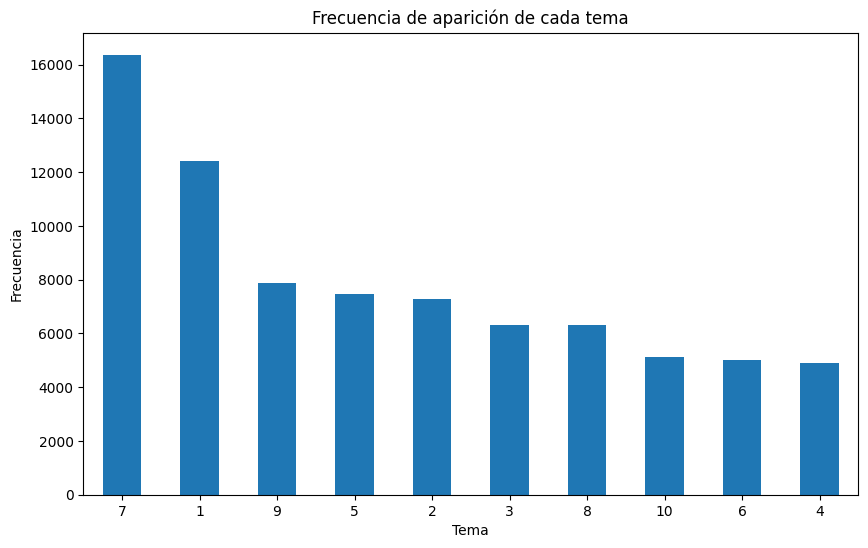

[10951, 20861, 1765, 4268, 9867, 2663, 17269, 12458, 15025, 27553]
[11439, 9301, 19826, 24585, 11589, 24506, 10968, 19846, 10951, 12077]
[10822, 10702, 15314, 24980, 19826, 16842, 15129, 6740, 23212, 8595]
[11637, 24585, 11589, 20306, 26001, 10968, 16935, 5194, 23882, 2263]
[19234, 10702, 9301, 12750, 26001, 28951, 28190, 24564, 10139, 17233]
[15332, 16842, 1150, 1765, 6740, 3074, 4619, 22601, 2263, 24761]
[26001, 15564, 9910, 24585, 11380, 4847, 9291, 1727, 25832, 15314]
[20746, 15025, 9004, 17269, 20861, 20306, 6107, 24585, 17802, 9910]
[11200, 4268, 12750, 16610, 28811, 22166, 11380, 10651, 19846, 3752]
[28384, 16842, 24506, 9291, 10139, 28300, 11589, 27846, 28811, 17985]


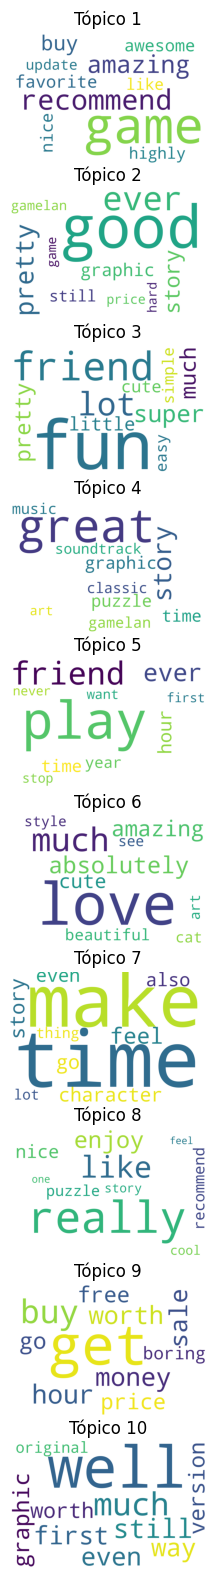

Modelo serializado correctamente


In [10]:
#Construir el vocabulario y detectar las palabras más influyentes en cada tópico
diccionario_topics,vocabulary = interpret_topics(components,nmf_object,bow_object)

#Ver la distribución de los documentos a los tópicos a los que se asigna

distribution_topics(bow,predominant_topics,algorithm='nmf_algorithm')

#Dibujar wordcloud de tópicos
worcloud_topics(n_componentes=components,algoritmo=nmf_object,vocabulary=vocabulary,file_name = 'nmf')


#Exportar el ccionario de tópicos a .json
export_json_topics('nmf',diccionario_topics)

#Serializamos la matriz W

with open('model_serialization/x_nmf.pkl','wb') as file:
    try:
        pickle.dump(nmf, file)
        print('Modelo serializado correctamente')
    except:
        print('El modelo no ha sido capaz de serializarse')
file.close()